In [1]:
using SpecialFunctions
function bessel_invert(x)
    @assert(x < .58)
    @assert(x > -.58)
    left = -1.84
    right = 1.84
    guess = besselj(1, (right+left)/2)
    while abs(guess - x) > 1E-5
        if guess < x
            left += (right - left)/2
        else
            right -= (right - left)/2
        end
        guess = besselj(1, (right+left)/2)
    end
    (right+left)/2
end
bessel_invert(-0.1)

-0.20102539062500002

In [2]:
num_points = 500
rs = LinRange(0, 1, num_points)
θs = LinRange(0, 2π, num_points)
pairs = [(r, θ) for r in rs for θ in θs]
xs = [pair[1] * cos(pair[2]) for pair in pairs]
ys = [pair[1] * sin(pair[2]) for pair in pairs]
xs = LinRange(-1, 1, num_points)
ys = LinRange(-1, 1, num_points)
function f(x, y; scale=1)
    r = sqrt(x^2 + y^2)
    if r1 < r < r2
        1*scale
    else
        0
    end
end

f (generic function with 1 method)

In [3]:
interionic_spacing = .2
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = 1
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, .5), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none);


In [4]:
function plot_triangles_across_unit_disk(f, x, y)
    infids = []
    ψ1s = []
    ψ2s = []
    for (i, xx) in enumerate(x)
        print(i)
        ρ = sqrt(xx^2 + y[i]^2)
        ϕ = atan(y[i], xx)
        infid, ψ1, ψ2 = f(ρ, ϕ)
        push!(infids, infid)
        push!(ψ1s, ψ1)
        push!(ψ2s, ψ2)
        end
    infids, ψ1s, ψ2s
end

plot_triangles_across_unit_disk (generic function with 1 method)

In [ ]:
using SpecialFunctions
using QuantumOptics

function infidelity(ρ, σ)
    print(ρ, σ)
    1 - abs(ρ'*σ)^2
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = (n)
            k = (k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    Pevens = []
    eventuples = []
    for (m, zeven) in enumerate(zernike_coefficients_even)
        meven = m - 1
        push!(Pevens, [zeven[i] * R(i-1, meven, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = sum(Pevens[i])
        push!(eventuples, (i - 1, total, rotationeven))
    end
    eventuples # No odd tuples, so we'll leave it simple. (In fact, only m=0 again but we'll test this.)
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

In [ ]:
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = (n)
            k = (k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end


In [ ]:
max_n = 40
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(0, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

In [ ]:
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = (n)
            k = (k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n, m, ρ, θ)
    if m < 0
        R(n, abs(m), ρ) * sin(abs(m) * θ)
    else
        R(n, m, ρ) * cos(m * θ)
    end
end

In [ ]:
# r1 = .45
# r2 = .55
# decay = .01

r1 = .45
r2 = .55
decay = .1
function annulus(ρ, θ)
    mid = r1 + .5  * (r2 - r1)
    max = (-1/(1 + exp(-1/decay*(mid-r2))) +   1/(1 + exp(-1/decay*(mid-r1))))
    ((-1/(1 + exp(-1/decay*(ρ-r2))) +   1/(1 + exp(-1/decay*(ρ-r1)))))/max
end
function integrand(n, m)
    function rtn(coor)
        ρ = coor[1]
        θ = coor[2]
        x = ρ * cos(θ)
        y = ρ * sin(θ)
        Z(n, m, ρ, θ) * annulus(ρ, θ) * ρ
    end
    rtn
end

In [ ]:
using Cubature
function cond_eval(n, m)
    if -n ≤ m ≤ n
        (2*n+2)/(π*2) * hcubature(integrand(n, m), [0., 0.], [1., 2*π], maxevals=10000)[1]
    else
        0
    end
end
max_n = 20
data = [cond_eval(i, 0) for i in range(0, max_n, step=1)];

In [ ]:
function recon(ρ, ϕ)
    t = 0
    for (n, el) in enumerate(data)
        t += el*Z(n-1,0,ρ, 0)
    end
    t
end
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)                
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end
num_points = 10
xx, yy, samples =  sample_across_unit_disk(recon, num_points)
using LaTeXStrings
#p = palette([:white, :black], 100)
#plot(heatmap(xx, yy, amp*abs.(samples), c=p),aspectratio=true, legend=false, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Absolute Reconstruction Error for Annulus}", fontfamily="Computer Modern")


In [ ]:
maxn = 12
maxm = 0
lookup = Dict()
for n in range(0, maxn, step=1)
    for m in range(0, maxm, step=1)
        for (i, pair) in enumerate(collect(zip(x, y)))
            xx = pair[1]
            yy = pair[2]
            ρ = sqrt(xx^2 + yy^2)
            # lookup with five digits of accuracy
            ρ = Int(round(ρ * 10^3, digits=0))
            lookup[(ρ, n, m)] = data[n+1] * R(n, m, sqrt(xx^2 + yy^2))
        end
    end
end
ω = 2*π*180E3
θ = -π/2;
U = 2 * π * 10E3
amp = .5
evolution_time = π/(2*U*amp)
finals = []
for (i, xx) in enumerate(x)
    yy = y[i]
    ρ = sqrt(xx^2 + yy^2)
    ϕ = atan(yy, xx)
    final = 0
    ρ = Int(round(ρ * 10^3, digits=0))
    for m in range(0, maxm, step=1)
        pm = 0
        for n in range(0, maxn, step=1)
            if n ≥ m
                pm += lookup[(ρ, n, m)]
            end
        end
        inverted = bessel_invert(amp*pm)
        total = U*besselj(1, inverted)*sin(m*ϕ-θ)*evolution_time
        maxpower = 100
        for k in range(-maxpower, maxpower, step=1)
            if k!=1 && m!=0
                a = U*exp(1.0im * (θ + k*m*ϕ)) * (1.0im)^(k+1)/(2*(k-1)*m*ω) * besselj(k, inverted)*(1 - exp(-1.0im*(k-1)*m*ω*evolution_time))
                total += a + conj(a)
            end
        end
        final += total
    end
    push!(finals, final)
end

In [ ]:
evolution_time

In [ ]:
using LaTeXStrings

function phase(x, y)
    scale = 1
    ρ = sqrt(x^2 + y^2)/scale
    mid = r1 + .5  * (r2 - r1)
    max = (1 - 1/(1 + exp(-1/decay*(mid-r2))) +   1/(1 + exp(-1/decay*(mid-r1)))) - 1
    if ρ > 1
        -1
    else
        2*((1 - 1/(1 + exp(-1/decay*(ρ-r2))) +   1/(1 + exp(-1/decay*(ρ-r1)))) - 1)/max - 1
    end
end

p = palette([:white, :black], 100);
scale = 1
plot(heatmap(xs, ys, phase; c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [Real(cos(2*f)) for f in finals], c=p, clim  = (-1,1))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\left\langle\sigma_x\right\rangle\textrm{ for Annulus}", fontfamily="Computer Modern")

In [ ]:
function ann(x, y)
    phase = annulus(sqrt(x^2 + y^2), atan(y, x))
    1/sqrt(2) * [exp(-1.0im * π/2 * phase), exp(1.0im * π/2 * phase)]
end

ϕ = [ann(xx, y[i]) for (i, xx) in enumerate(x)];
ψ = [1/sqrt(2)*[exp(-1.0im * (f)), exp(1.0im * (f))] for f in finals];
infidsparallel = [infidelity(ϕϕ, ψ[i]) for (i, ϕϕ) in enumerate(ϕ)];

In [ ]:
using LaTeXStrings
z = abs.(infidsparallel)
function phase(x, y)
    ρ = sqrt(x^2 + y^2)/scale
    mid = r1 + .5  * (r2 - r1)
    max = (1 - 1/(1 + exp(-1/decay*(mid-r2))) +   1/(1 + exp(-1/decay*(mid-r1)))) - 1
    if ρ > 1
        minimum(log.(10, z))
    else
        (maximum(log.(10, z)) - minimum(log.(10, z)))*((1 - 1/(1 + exp(-1/decay*(ρ-r2))) +   1/(1 + exp(-1/decay*(ρ-r1)))) - 1)/max + minimum(log.(10, z))
    end
end
scale = 10
plot(heatmap(scale*xs, scale*ys, phase; c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = log.(10, z), c=palette([:white, :black], 100))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Log Infidelity for Annulus}", fontfamily="Computer Modern")

# Completely Serial

In [17]:
maxn = 20
maxm = 0
lookup = Dict()
for n in range(0, maxn, step=1)
    for m in range(0, maxm, step=1)
        for (i, pair) in enumerate(collect(zip(x, y)))
            xx = pair[1]
            yy = pair[2]
            ρ = sqrt(xx^2 + yy^2)
            # lookup with five digits of accuracy
            ρ = Int(round(ρ * 10^3, digits=0))
            lookup[(ρ, n, m)] = data[n+1] * R(n, m, sqrt(xx^2 + yy^2))
        end
    end
end
ω = 2*π*180E3
θ = -π/2;
U = 2 * π * 10E3
amp = .4
evolution_time = π/(U*amp)
finals = []
for (i, xx) in enumerate(x)
    yy = y[i]
    ρ = sqrt(xx^2 + yy^2)
    ϕ = atan(yy, xx)
    final = 0
    ρ = Int(round(ρ * 10^3, digits=0))
    for m in range(0, maxm, step=1)
        pm = 0
        for n in range(0, maxn, step=1)
            if n ≥ m
                pm += lookup[(ρ, n, m)]
            end
        end
        #inverted = bessel_invert(amp*pm)
        total = U*besselj(1, amp*pm)*sin(m*ϕ-θ)*evolution_time
        maxpower = 100
        for k in range(-maxpower, maxpower, step=1)
            if k!=1 && m!=0
                a = U*exp(1.0im * (θ + k*m*ϕ)) * (1.0im)^(k+1)/(2*(k-1)*m*ω) * besselj(k, amp*pm)*(1 - exp(-1.0im*(k-1)*m*ω*evolution_time))
                total += a + conj(a)
            end
        end
        final += total
    end
    push!(finals, final)
end

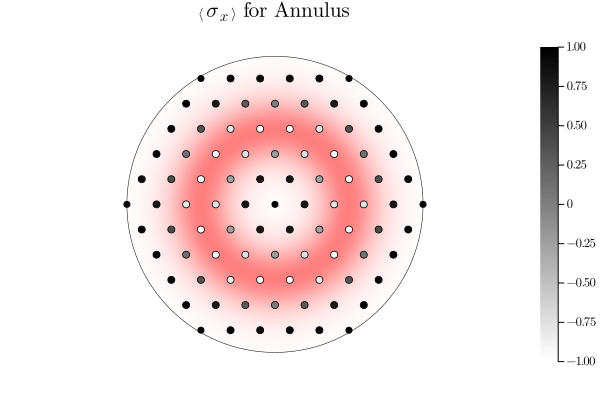

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [305]:
using LaTeXStrings

function phase(x, y)
    scale = 1
    ρ = sqrt(x^2 + y^2)/scale
    mid = r1 + .5  * (r2 - r1)
    max = (1 - 1/(1 + exp(-1/decay*(mid-r2))) +   1/(1 + exp(-1/decay*(mid-r1)))) - 1
    if ρ > 1
        -1
    else
        2*((1 - 1/(1 + exp(-1/decay*(ρ-r2))) +   1/(1 + exp(-1/decay*(ρ-r1)))) - 1)/max - 1
    end
end

p = palette([:white, :black], 100);
scale = 1
plot(heatmap(xs, ys, phase; c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [Real(cos(2*f)) for f in finals], c=p, clim  = (-1,1))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\left\langle\sigma_x\right\rangle\textrm{ for Annulus}", fontfamily="Computer Modern")

In [306]:
function ann(x, y)
    phase = annulus(sqrt(x^2 + y^2), atan(y, x))
    1/sqrt(2) * [exp(-1.0im * π/2 * phase), exp(1.0im * π/2 * phase)]
end

ϕ = [ann(xx, y[i]) for (i, xx) in enumerate(x)];
ψ = [1/sqrt(2)*[exp(-1.0im * (f)), exp(1.0im * (f))] for f in finals];
infids = [infidelity(ϕϕ, ψ[i]) for (i, ϕϕ) in enumerate(ϕ)];

Complex{Float64}[0.706411131115576 - 0.031357835320896386im, 0.706411131115576 + 0.031357835320896386im]Complex{Float64}[0.7060818470984881 - 0.03805818174830693im, 0.7060818470984881 + 0.03805818174830693im]Complex{Float64}[0.677336159425789 - 0.2030165686202041im, 0.677336159425789 + 0.2030165686202041im]Complex{Float64}[0.6770840982878498 - 0.20385564462562555im, 0.6770840982878498 + 0.20385564462562555im]Complex{Float64}[0.24263753264793417 - 0.6641739438961172im, 0.24263753264793417 + 0.6641739438961172im]Complex{Float64}[0.2510431069795445 - 0.6610426298190283im, 0.2510431069795445 + 0.6610426298190283im]Complex{Float64}[0.1917155596484746 - 0.6806211458577173im, 0.1917155596484746 + 0.6806211458577173im]Complex{Float64}[0.20240818251360995 - 0.677518212044176im, 0.20240818251360995 + 0.677518212044176im]Complex{Float64}[0.6690849007157414 - 0.22874744945945585im, 0.6690849007157414 + 0.22874744945945585im]Complex{Float64}[0.6689245812451979 - 0.22921584719634136im, 0.66892458124

im, 0.04162862075341427 + 0.7058803425044278im]Complex{Float64}[0.016128636685761644 - 0.7069228155029788im, 0.016128636685761644 + 0.7069228155029788im]Complex{Float64}[0.03775723227299651 - 0.7060980041120941im, 0.03775723227299651 + 0.7060980041120941im]Complex{Float64}[0.42272440287438273 - 0.5668369070680706im, 0.42272440287438273 + 0.5668369070680706im]Complex{Float64}[0.42587687762073173 - 0.564472218189714im, 0.42587687762073173 + 0.564472218189714im]Complex{Float64}[0.24263753264793417 - 0.6641739438961172im, 0.24263753264793417 + 0.6641739438961172im]Complex{Float64}[0.2510431069795445 - 0.6610426298190283im, 0.2510431069795445 + 0.6610426298190283im]Complex{Float64}[0.1917155596484746 - 0.6806211458577173im, 0.1917155596484746 + 0.6806211458577173im]Complex{Float64}[0.20240818251360995 - 0.677518212044176im, 0.20240818251360995 + 0.677518212044176im]Complex{Float64}[0.6690849007157414 - 0.22874744945945585im, 0.6690849007157414 + 0.22874744945945585im]Complex{Float64}[0.6689

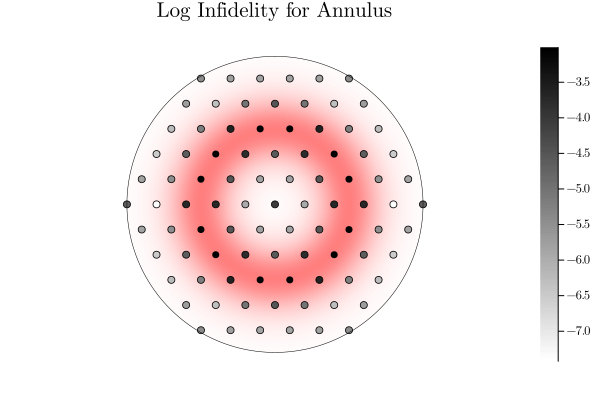

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [307]:
using LaTeXStrings
z = abs.(infids)
function phase(x, y)
    ρ = sqrt(x^2 + y^2)/scale
    mid = r1 + .5  * (r2 - r1)
    max = (1 - 1/(1 + exp(-1/decay*(mid-r2))) +   1/(1 + exp(-1/decay*(mid-r1)))) - 1
    if ρ > 1
        minimum(log.(10, z))
    else
        (maximum(log.(10, z)) - minimum(log.(10, z)))*((1 - 1/(1 + exp(-1/decay*(ρ-r2))) +   1/(1 + exp(-1/decay*(ρ-r1)))) - 1)/max + minimum(log.(10, z))
    end
end
scale = 10
plot(heatmap(scale*xs, scale*ys, phase; c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = log.(10, z), c=palette([:white, :black], 100))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Log Infidelity for Annulus}", fontfamily="Computer Modern")

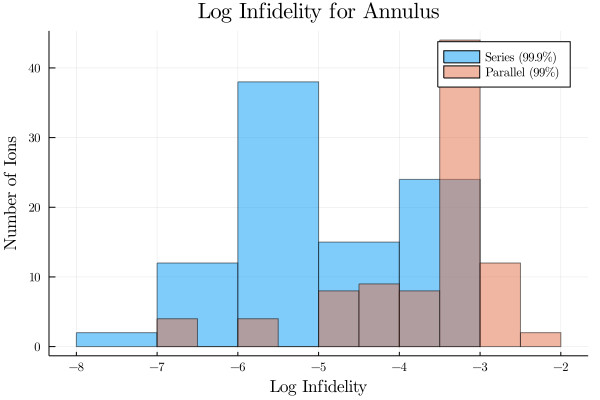

In [309]:
σ1 = .1
σ2 = .1  
using LaTeXStrings
using Plots

histogram(log.(10, infids), alpha=.5, label="Series (99.9%)", xlabel="Log Infidelity", ylabel="Number of Ions", title="Log Infidelity for Annulus",  fontfamily="Computer Modern")
#histogram!(log.(10, z2), alpha=.5, label="")
histogram!(log.(10, infidsparallel), alpha=.5, label="Parallel (99%)")